In [1]:
import matplotlib.pyplot as plt
from src.invert_c_theta import Invert
import pandas as pd
import firedrake

2025-10-30 00:52:22.216064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 00:52:24.034039: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 00:52:24.843713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761785545.572944   79155 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761785545.772688   79155 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 00:52:27.435761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# drichlet_ids = [1,2,5,6,7,8,9,10,11] #dotson-crosson.geojson
# drichlet_ids = [1,2,3,4,5,6,7,9,10,11,12,13,14,15] #dotson-crosson-v1.geojson
drichlet_ids = [1,3,5,6,7,8,9,10,11]
side_ids = []
invert_amundsen = Invert(outline = 'data/geojson/amundsen_v1.geojson', mesh_name = 'amundsen',reg_constant_c  = 0.05, read_mesh = False,opts = None, drichlet_ids = drichlet_ids , lcar = 9e3)

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='meters'>)

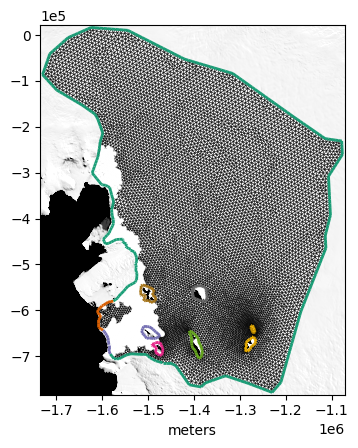

In [3]:
invert_amundsen.plot_mesh()

In [4]:
invert_amundsen.import_velocity_data(constant_val=0.01)

Reading velocity from measures database
C0 is constant: 0.01
Defining friction law


In [5]:
invert_amundsen.import_geophysics_data(name_list=['data/geophysics/ADMAP_2S_epsg3031_gdal.tif', 
                                                'data/geophysics/ANTGG_BouguerAnomaly_10km_MF_combined_2.tif', # interpolated using multifidelity modeling
                                                'data/geophysics/GeothermalHeatFlux_5km.tif',
                                                'data/geophysics/ALBMAP_SurfaceAirTemperature_5km.tif',
                                                'data/geophysics/AntGG2021_Gravity_disturbance_at-surface_grav_dist.tif',
                                                'data/geophysics/ALBMAP_SnowAccumulation_Arthern_5km.tif',
                                                'data/geophysics/Englacial_temp_Pattyn_2013.tif',
                                                'data/geophysics/bed_class_oct29_2025.tif'])

Defining friction law
using englacial temperature for rate factor
Geophysics data imported


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Englacial Temperature'}, xlabel='meters'>)

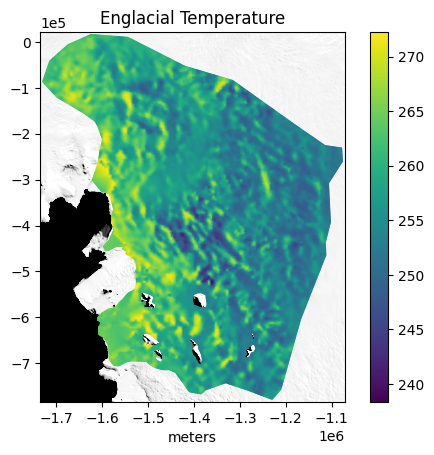

In [6]:
invert_amundsen.plot_englacial_temp()

In [7]:
invert_amundsen.invert_C(max_iterations=200, regularization_grad_fcn= True, loss_fcn_type = 'nosigma')

Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.634803e+08   9.215758e+03                  2.394417e+04   
  1     1.257310e+08   3.610559e+03   2.394417e+04   5.986044e+04   3         2         0         1         3         
  2     2.817503e+07   1.063957e+03   5.986044e+04   1.496511e+05   4         3         0         3         2         
  3     2.817503e+07   1.063957e+03   1.496511e+05   9.353193e+03   5         3         2         3         2         
  4     2.035817e+07   6.603725e+02   9.353193e+03   2.338298e+04   6         4         0         1         3         
  5     1.055754e+07   2.702426e+02   2.338298e+04   5.845746e+04   7         5         0         2         3         
  6     1.055754e+07   2.702426e+02   5.845746e+04   3.653591e+03   8         5         2         2         3         
  7     9.624853e+06   2.41107

In [8]:
u_optimized =  invert_amundsen.simulation()

In [9]:
firedrake.assemble(invert_amundsen.loss_functional_nosigma(u_optimized))
# 200 iter: 2450.364047776876

2450.364047776876

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='UPS x [m]', ylabel='UPS y [m]'>)

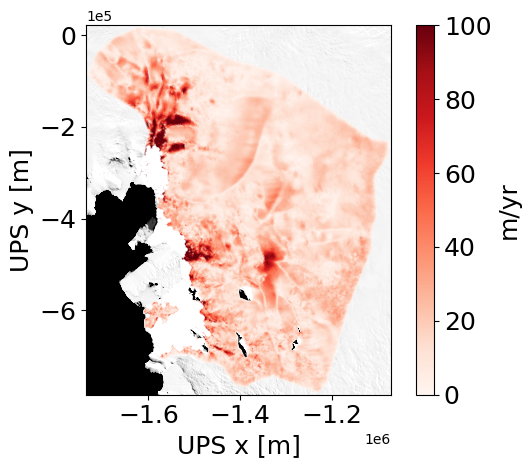

In [10]:
invert_amundsen.plot_u_error_no_sigma(u_optimized, vmax = 100)

In [11]:
def plot_C_obj(obj, vmin=-2, vmax=3, title=False):
    """Plot C (standalone version)."""
    fig, axes = obj.plot_bounded_antarctica()
    axes.set_xlabel("UPS x [m]", fontsize=18)
    axes.tick_params(axis='x', labelsize=18)
    axes.tick_params(axis='y', labelsize=18)

    colors = firedrake.tripcolor(obj.C, axes=axes)
    colors.set_clim(vmin, vmax)  # Set color limits on the ScalarMappable

    cbar = fig.colorbar(colors)
    #cbar.set_label("C", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Overlay white dots over floating ice (no label)
    phi = obj.get_phi(obj.h, obj.s)
    Q_temp = firedrake.FunctionSpace(obj.mesh, family="CG", degree=1)
    line = firedrake.interpolate(phi, Q_temp)
    phi_values = line.dat.data[:]
    x = line.function_space().mesh().coordinates.dat.data[:, 0]
    y = line.function_space().mesh().coordinates.dat.data[:, 1]
    x_coords = x[(phi_values <= 0.1 + 0.01)]
    y_coords = y[(phi_values <= 0.1 + 0.01)]
    if len(x_coords) > 0:
        axes.scatter(x_coords, y_coords, color='white', s=7)
    if title:
        axes.set_title("C")
    return fig, axes

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='UPS x [m]'>)

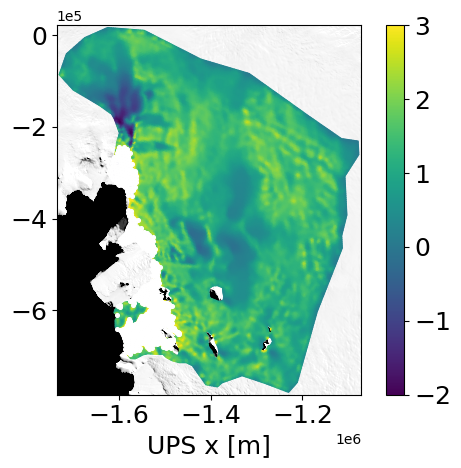

In [12]:
plot_C_obj(invert_amundsen, title = False, vmin = -2, vmax =3 )

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '% Error in U'}, xlabel='meters'>)

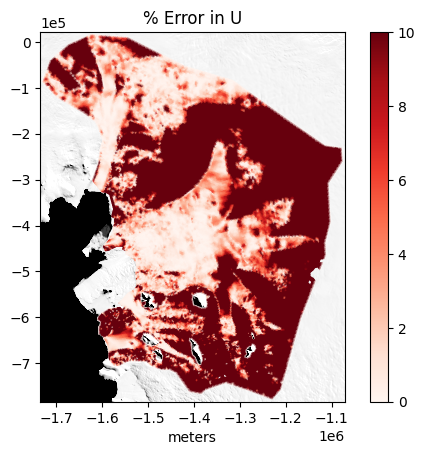

In [13]:
invert_amundsen.plot_u_error_percentage(u_optimized, vmax = 10)

In [14]:
C_optimized = invert_amundsen.get_C()

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='UPS x [m]'>)

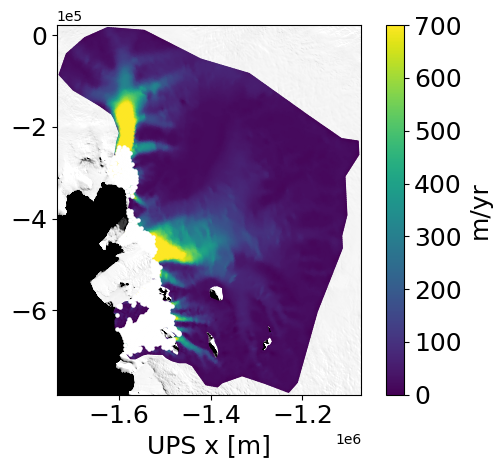

In [15]:
invert_amundsen.plot_u_mag(u_optimized, vmax=700)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'C'}, xlabel='UPS x [m]'>)

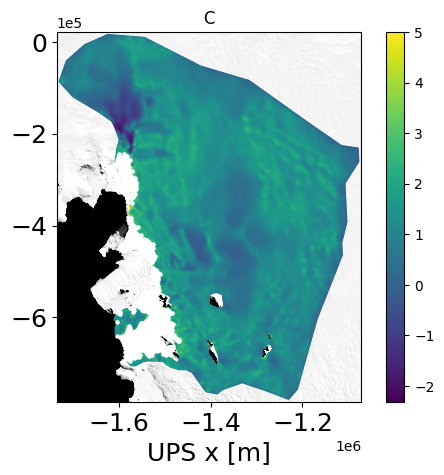

In [16]:
invert_amundsen.plot_C(vmax = 5)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '$C_{b}$'}, xlabel='meters'>)

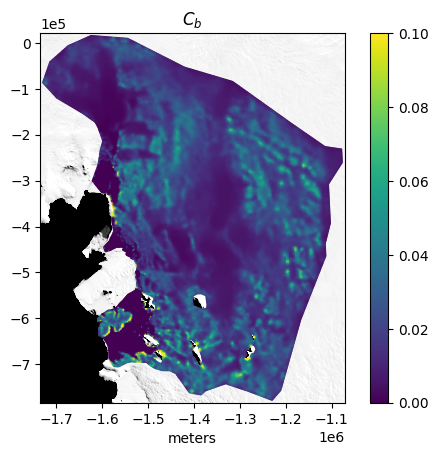

In [17]:
invert_amundsen.plot_C_total(vmax = 0.1)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Grounding Line'}, xlabel='meters'>)

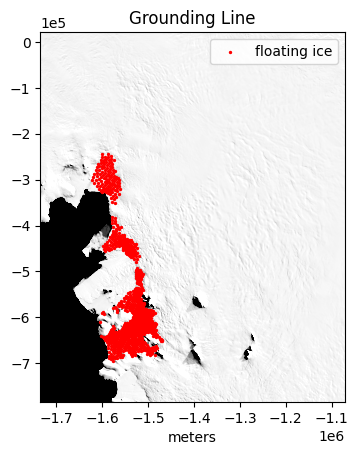

In [18]:
invert_amundsen.plot_grounding_line()

In [19]:
#invert_dotson.inverse_u = invert_dotson.u_initial
invert_amundsen.inverse_u = u_optimized

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='meters'>)

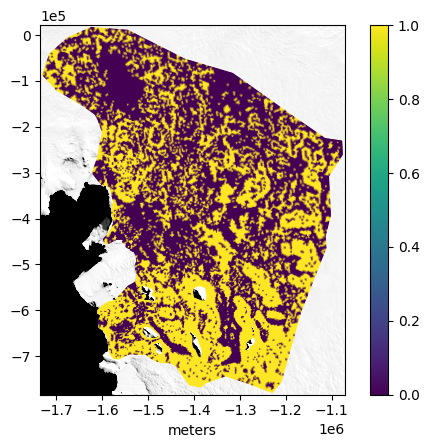

In [33]:
invert_amundsen.plot_scalar_field(invert_amundsen.bed_class, vmin=0, vmax=1)

In [20]:
#theta = invert_dotson.θ
C = invert_amundsen.C

In [21]:
df = invert_amundsen.get_dataframe(u_optimized)
df.to_csv('regularized_const_01C_C_only_englacial_temp_amundsen_r005_geo_12_bed_class_updated_geo.csv')

In [42]:
import numpy as np

# make a copy so original df is not overwritten
df_bed = df.copy()

conds = [
    (df_bed['bed_class'] > 0.5) & (df_bed['bed_class'] <= 1.5),
    (df_bed['bed_class'] > 1.5) & (df_bed['bed_class'] <= 2.5),
    (df_bed['bed_class'] > 2.5) & (df_bed['bed_class'] <= 3.5),
]
choices = [1, 2, 3]

df_bed['bed_class_int'] = np.select(conds, choices, default=0).astype(np.int8)

# quick check
print(df_bed['bed_class_int'].value_counts(dropna=False))
df_bed['bed_class'] = df_bed['bed_class_int']

bed_class_int
0    1274938
2     225692
3      19941
1       9480
Name: count, dtype: int64


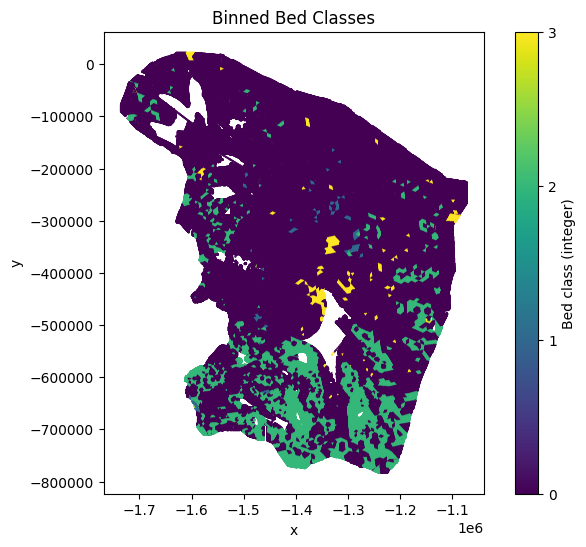

In [43]:
# scatter plot of the binned bed classes
plt.figure(figsize=(8,6))
vmin, vmax = 0, 3
sc = plt.scatter(df_bed['x'], df_bed['y'], c=df_bed['bed_class'], cmap='viridis', s=0.1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sc, ticks=[0,1,2,3])
cbar.set_label('Bed class (integer)')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Binned Bed Classes')
plt.gca().set_aspect('equal', 'box')
plt.show()


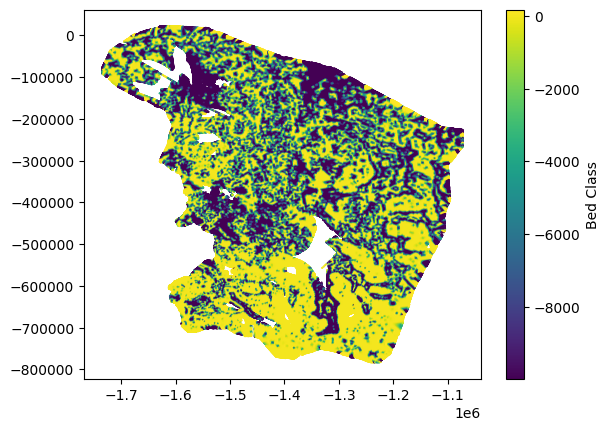

In [41]:
vmin = df['bed_class'].quantile(0.10)
vmax = df['bed_class'].quantile(0.90)
plt.scatter(df['x'], df['y'], c=df['bed_class'], cmap='viridis', s=0.1, vmin=vmin, vmax=vmax)
plt.colorbar(label='Bed Class')